In [1]:
import pandas as pd
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = "../data/"

data_path = os.path.join(DATA_DIR, "new_data.csv")
df = pd.read_csv(data_path)[["Message","R2DiscussionType"]]
df = df.dropna()

display(df)
X = df["Message"]
Y = df["R2DiscussionType"]

Y_clean = Y.str.contains(",")

Y = Y[~Y_clean]
X = X[~Y_clean]

,Message,R2DiscussionType
0,Hello.,Social
1,My assumption is,Seminar
2,that the emphasis on barbarism implies that sh...,Seminar
3,I agree with Cassandra's noticing,Seminar
4,of the author's word choice of barbarism.,Seminar
...,...,...
606,P2: The king may send his daughter to the aren...,Seminar
607,I have no guess as to which is behind the door...,Seminar
608,Part 2: The daughter is “the apple of the king...,Seminar
609,"Part 1: Honestly hard to say, though I'd like ...",Seminar


# explore the data

In [3]:
onehot_lookup = np.array(Y.unique())
onehot_lookup

array(['Social', 'Seminar', 'Procedure', 'Other', 'Deliberation', 'UX',
       'Imaginative entry', 'Imaginative'], dtype=object)

In [4]:
def from_onehot(data:np.ndarray):
  data = np.argmax(data, axis=1)
  return onehot_lookup[data]

def to_onehot(data:np.ndarray):
  key=np.argsort(onehot_lookup)
  result=key[onehot_lookup[key].searchsorted(data)]

  out = np.zeros((data.shape[0], onehot_lookup.size))
  out[np.arange(out.shape[0]),result] = 1
  return out

In [5]:
print(Y.value_counts())
Y_onehot= to_onehot(Y.to_numpy())
# print(Y[3])
# print(Y_onehot[3])

R2DiscussionType
Seminar              333
Deliberation          85
Social                69
UX                    47
Procedure             46
Imaginative entry     18
Other                  6
Imaginative            2
Name: count, dtype: int64


In [6]:
index = 8
test = Y[index]
a = Y_onehot[index]
a = np.array([a])   
print(index, test, from_onehot(a))

8 Procedure ['Procedure']


# Generate sentence embeddings

In [7]:
embeding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
X_embeddings = embeding_model.encode(X.to_numpy())

In [8]:
print(X_embeddings.shape)

(606, 384)


In [9]:
import torch
from torch import nn

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
from sklearn.model_selection import train_test_split


X = torch.tensor(X_embeddings).float().to(device)
Y = torch.tensor(Y_onehot).float().to(device)
display(X.shape, Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

torch.Size([606, 384])

torch.Size([606, 8])

In [11]:
from model import NeuralNet

num_epochs = 3000
learning_rate = 1e-4

model = NeuralNet(X.shape[1], 30, Y.shape[1]).to(device)
# # Loss and optimizer
# def CEL_with_l2(y_hat, y, model):
#   criterion = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [12]:

total_step = len(X)
for epoch in range(num_epochs):
    # for i, (inputs, labels) in enumerate(zip(X, Y)):  
    # Move tensors to the configured device
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backprpagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        train_loss = loss.item()

        # test
        with torch.no_grad():
            model.train(False)
            outputs = model(X_test)
            loss = criterion(outputs, y_test)
            test_loss = loss.item()
            model.train(True)
            
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}' 
                .format(epoch+1, num_epochs, train_loss, test_loss))

Epoch [100/3000], Train Loss: 2.0586, Test Loss: 2.0560
Epoch [200/3000], Train Loss: 1.9688, Test Loss: 1.9722
Epoch [300/3000], Train Loss: 1.7697, Test Loss: 1.7407
Epoch [400/3000], Train Loss: 1.4811, Test Loss: 1.4007
Epoch [500/3000], Train Loss: 1.3289, Test Loss: 1.2156
Epoch [600/3000], Train Loss: 1.2462, Test Loss: 1.1308
Epoch [700/3000], Train Loss: 1.2294, Test Loss: 1.0781
Epoch [800/3000], Train Loss: 1.1244, Test Loss: 1.0378
Epoch [900/3000], Train Loss: 1.1019, Test Loss: 1.0044
Epoch [1000/3000], Train Loss: 1.0714, Test Loss: 0.9783
Epoch [1100/3000], Train Loss: 1.0025, Test Loss: 0.9571
Epoch [1200/3000], Train Loss: 1.0263, Test Loss: 0.9411
Epoch [1300/3000], Train Loss: 0.9836, Test Loss: 0.9272
Epoch [1400/3000], Train Loss: 0.9389, Test Loss: 0.9155
Epoch [1500/3000], Train Loss: 0.9358, Test Loss: 0.9054
Epoch [1600/3000], Train Loss: 0.8764, Test Loss: 0.8964
Epoch [1700/3000], Train Loss: 0.8908, Test Loss: 0.8885
Epoch [1800/3000], Train Loss: 0.8707, T

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

with torch.no_grad():
  model.train(False)
  y_hat = model(X_test)

Y_amax = y_test.detach().cpu().numpy()
Y_hat_amax = y_hat.detach().cpu().numpy()

cm = confusion_matrix(from_onehot(Y_amax),from_onehot(Y_hat_amax))

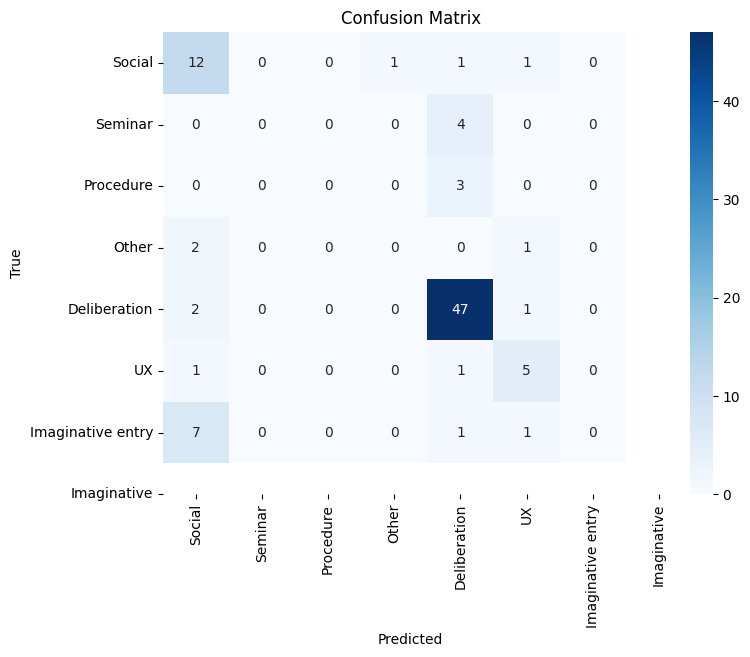

In [14]:
# Create confusion matrix

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=onehot_lookup, yticklabels=onehot_lookup)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# custom prediction

In [21]:
text = ["Hey, greetings", "I belive that the lion lived because of the princesses decision", "job submited"]
embedded = embeding_model.encode(text)
embedded = torch.tensor(embedded) 
with torch.no_grad():
  out = model(embedded)

print(from_onehot(out))

['Social' 'Seminar' 'Procedure']


/tmp/ipykernel_219410/1184356501.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


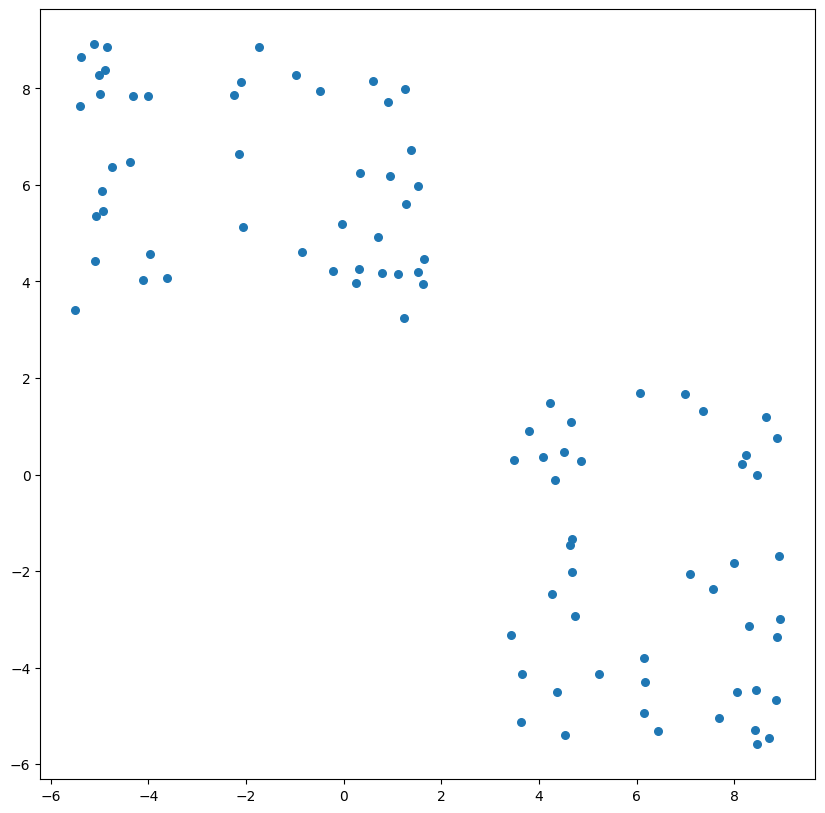

In [19]:
from sklearn.manifold import TSNE


with torch.no_grad():
  model.train(False)
  y_hat = model(X_test)

tsne = TSNE(n_components=2, random_state=0, perplexity=40)
out = tsne.fit_transform(y_hat).reshape(2, -1)

fig, axis= plt.subplots(1,1, figsize=(10, 10))
axis.scatter(out[0], out[1], s=30)
fig.show()
# for i,t in enumerate(data):
#   axis.text(out[0][i], out[1][i], t, fontsize=7)